In [1]:
### 입력으로 상호명을 받으면 업종분류를 반환하는 프로그램

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import time
import os

from tqdm import tqdm
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizerFast, BertConfig, BertModel # Bert 모델과 토크나이저
from torch.utils.data import Dataset, DataLoader
from collections import Counter

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

c:\code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.init()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=None)
print("현재 디바이스:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

현재 디바이스: cuda


In [3]:
# 전처리된 CSV 파일 로드
def load_processed_data(file_path):
    """
    처리된 CSV 파일을 로드하는 함수
    """
    df = pd.read_csv(file_path)
    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")
    
    # 필요한 열만 추출 (업체명과 클래스)
    result_df = df[['상호명_Regulated', '클래스']].copy()
    
    # 컬럼명 통일
    result_df.columns = ['store', 'class']
    
    print(f"전처리 후 데이터 크기: {result_df.shape}")
    return result_df

In [4]:
data_df = load_processed_data('./processed_data/region_all_processed_data_remap.csv')

로드된 데이터 크기: (1818083, 5)
컬럼 목록: ['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']
전처리 후 데이터 크기: (1818083, 2)


In [5]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    데이터를 훈련용과 테스트용으로 분할하는 함수
    """
    # 클래스 분포 확인
    num_classes = df['class'].nunique()
    print(f"고유 클래스 수: {num_classes}")
    
    # 데이터셋 분할 (stratify로 클래스 분포 유지)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['class']
    )
    
    print(f"훈련 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

    return train_df, test_df

In [6]:
train_df, test_df = split_dataset(data_df)

고유 클래스 수: 125
훈련 데이터 크기: (1454466, 2)
테스트 데이터 크기: (363617, 2)


In [7]:
# 클래스별 샘플 수 세기
class_counts = Counter(train_df['class'])
num_classes = len(class_counts)
# 클래스 인덱스 매핑
class_to_idx = {cls: i for i, cls in enumerate(sorted(class_counts.keys()))}

In [8]:
train_df
# test_df

,store,class
1285953,웅천점,89
1418434,작은별밭,96
1055247,짐보리가산마리오센터,76
477781,태백지업사,8
120700,테크노생활용품,99
...,...,...
467280,통영인가,119
1418826,삼화주구,77
1364195,우림특장산업,91
70716,에스알이노비트,15


In [9]:
train_df.groupby(by=['class']).count()

,store
class,
0,6016
1,576
2,4645
3,6629
4,4980
...,...
120,10633
121,978
122,731


In [10]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
token1 = tokenizer.tokenize("봉암쇼핑")
token2 = tokenizer.tokenize("밀사랑손칼국수")
token3 = tokenizer.tokenize("태민건축적산사무소")
token4 = tokenizer.tokenize("스타벅스R리저브강남대로점")
token5 = tokenizer.tokenize("로그인커피")
token6 = tokenizer.tokenize("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')
token1 = mecab.morphs("봉암쇼핑")
token2 = mecab.morphs("밀사랑손칼국수")
token3 = mecab.morphs("태민건축적산사무소")
token4 = mecab.morphs("스타벅스R리저브강남대로점")
token5 = mecab.morphs("로그인커피")
token6 = mecab.morphs("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

['봉', '##암', '##쇼핑'] ['밀', '##사랑', '##손', '##칼국수'] ['태', '##민', '##건축', '##적', '##산', '##사무소'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##대로', '##점'] ['로그인', '##커피'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##속', '##편한', '##치', '##과', '##건', '##너', '##편', '##점']
['봉암', '쇼핑'] ['밀사', '랑', '손칼국수'] ['태민', '건축', '적', '산', '사무소'] ['스타', '벅스', 'R', '리저브', '강남대로', '점'] ['로그인', '커피'] ['스타', '벅스', 'R', '리저브', '강남', '속편', '한', '치과', '건너편', '점']


In [11]:
class TokenDataset(Dataset):
    def __init__(self, dataframe, tokenizer_pretrained):
        self.data = dataframe
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['store']
        label = self.data.iloc[idx]['class']
        tokens = self.tokenizer(
            str(sentence),
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=60,
            add_special_tokens=True
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)
        token_type_ids = torch.zeros_like(attention_mask)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

In [12]:
train_data = TokenDataset(train_df, 'kykim/bert-kor-base')
test_data = TokenDataset(test_df, 'kykim/bert-kor-base')

# DataLoader로 이전에 생성한 Dataset를 지정하여, batch 구성, shuffle, num_workers 등을 설정합니다.
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [12]:
# 1개의 batch 꺼내기
inputs, labels = next(iter(train_loader))

# 데이터셋을 device 설정
inputs = {k: v.to(device) for k, v in inputs.items()}
labels.to(device)

tensor([ 80,  35,  76, 117, 214, 213, 214,  66, 107,  33, 153, 150,  80,  60,
        183, 103, 214, 180,  18,  74, 214,  87, 228, 107, 112,  18,  91,  87,
         55,   6,  55, 127,  34, 184,  72, 231, 204, 147, 157,  55, 212, 214,
         34, 204,  11,  60,  80, 112, 214,  87, 134,  41,  66, 214, 241, 241,
        228,  91, 229, 216, 124,  85,  74, 103], device='cuda:0')

In [13]:
class BertCNNModel(nn.Module):
    def __init__(self, bert_pretrained, num_classes=247, dropout_rate=0.5, kernel_sizes=[2,3,4], num_filters=128):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_pretrained)
        
        # Conv -> BatchNorm -> ReLU -> MaxPool을 하나의 블록으로 묶어 가독성 및 성능 개선
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels=768,              # BERT의 출력 임베딩 차원
                    out_channels=num_filters,     # Conv 필터 개수
                    kernel_size=k                 # 커널 사이즈
                ),
                nn.BatchNorm1d(num_filters),      # 배치 정규화 추가
                nn.ReLU()                         # 활성화 함수
            )
            for k in kernel_sizes
        ])
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # BERT의 마지막 히든 상태를 [batch, embedding_dim, sequence_length] 형태로 변경
        x = outputs['last_hidden_state'].transpose(1, 2)
        
        # Sequential 블록에 ReLU가 포함되었으므로, forward 로직을 간소화
        conv_outs = [conv(x) for conv in self.convs]
        
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conv_outs]
        
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        logits = self.fc(cat)
        return logits

In [14]:
tokenizer_pretrained = 'kykim/bert-kor-base'
bert_tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
bert = BertCNNModel(tokenizer_pretrained, num_classes=len(class_to_idx)).to(device)
bert.to(device)

BertCNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
# loss 정의: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 정의: bert.paramters()와 learning_rate 설정
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [15]:
model_name = 'bert-kor-cnn4_remap'
time_date = '250624_2320'
save_path = f'./saved_model/{model_name}_{time_date}'

In [16]:
bert.load_state_dict(torch.load(save_path + f'/{model_name}_{time_date}.pth'))

<All keys matched successfully>

In [17]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
labels = pickle.load(open('./processed_data/category_mapping_remapped.pkl', 'rb'))
labels = {v: k for k, v in labels.items()}
labels

{'0': '가구',
 '1': '가발',
 '2': '가전제품',
 '3': '가전제품 수리',
 '4': '가정용품 수리',
 '5': '가죽/가방/신발 수선',
 '6': '가축 사료',
 '7': '건강보조식품',
 '8': '건설 자재',
 '9': '건어물/젓갈',
 '10': '건축 서비스',
 '11': '결혼 상담 서비스',
 '12': '경영 컨설팅',
 '13': '고용 알선 및 인력 공급업',
 '14': '곡물/곡분',
 '15': '광고업',
 '16': '구내식당',
 '17': '기계 및 장비 대여',
 '18': '기념품점',
 '19': '기숙사/고시원',
 '20': '기타 개인/가정용품 대여',
 '21': '기타 운송장비 대여',
 '22': '기타 음식점',
 '23': '김밥/만두/분식',
 '24': '꽃집',
 '25': '네일숍',
 '26': '담배/전자담배',
 '27': '독서실/스터디 카페',
 '28': '동남아식 음식점엄',
 '29': '동물병원',
 '30': '디자인 서비스',
 '31': '떡/한과',
 '32': '마사지/안마',
 '33': '만화방',
 '34': '목욕탕/사우나',
 '35': '문구/회화용품',
 '36': '미용실',
 '37': '반찬/식료품',
 '38': '버거',
 '39': '법무 서비스',
 '40': '병원',
 '41': '복사업',
 '42': '부동산 중개/대리',
 '43': '뷔페',
 '44': '빵/도넛',
 '45': '사무 지원 서비스',
 '46': '사무기기',
 '47': '사업시설 관리 서비스',
 '48': '사진기/기타 광학기기',
 '49': '사진촬영업',
 '50': '생맥주 전문점',
 '51': '생수/음료',
 '52': '서점',
 '53': '세탁소',
 '54': '셀프 빨래방',
 '55': '수산물',
 '56': '숙박',
 '57': '슈퍼마켓',
 '58': '스포츠 서비스',
 '59': '스포츠/레크리에

In [18]:
class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels
        
    def predict(self, sentence):
        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob = prediction.max(dim=1)[0].item() * 100
        result = self.labels[str(output)]
        return result, prob

In [19]:
predictor = CustomPredictor(bert, tokenizer, labels)

predict_time = 9999
for i in range(10):
    start_time = time.time()
    query = test_df.iloc[i]['store']
    pred, acc = predictor.predict(query)
    print(f'{query} -> {pred} ({acc:.2f}%)')
    end_time = time.time()
    elapsed_time = end_time - start_time
    if elapsed_time < predict_time:
        predict_time = elapsed_time
query = "스타벅스R리저브강남속편한치과건너편점"
pred = predictor.predict(query)
print(query, pred)
print(f"예측 소요 시간: {predict_time:.4f}초")

빛고을미용실 -> 미용실 (99.81%)
살롱드다윤 -> 미용실 (99.18%)
서니통상 -> 의류 (98.40%)
엘스케이중원팜 -> 슈퍼마켓 (85.14%)
꿈을 그리다 -> 숙박 (56.69%)
서울페이 qr키트 -> 한식 음식점 (59.65%)
한국사회적기업중앙협의회충북지부 -> 경영 컨설팅 (91.13%)
떡볶이대첩 -> 김밥/만두/분식 (99.89%)
호반배곧나라공인중개사사무소 -> 부동산 중개/대리 (71.74%)
씨유포천미르점 -> 편의점 (55.91%)
스타벅스R리저브강남속편한치과건너편점 ('카페', 88.83723616600037)
예측 소요 시간: 0.0169초


In [21]:
pred = predictor.predict("에스.티.피.시 짱치")
print(f"예측 결과: {pred[0]}, 확률: {pred[1]:.2f}%")

예측 결과: 한식 음식점, 확률: 93.14%


In [22]:
def batch_predict(model, dataloader, labels_dict, device, test_df):
    # 배치 단위로 예측 수행
    model.eval()
    results = []
    idx = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            batch_size = len(labels)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            # 예측 수행
            outputs = model(**inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            # 결과 저장
            for i in range(batch_size):
                pred_class = labels_dict[str(preds[i].item())]
                true_class = labels_dict[str(labels[i].item())]
                results.append({
                    'query': test_df.iloc[idx]['store'],
                    'pred': pred_class,
                    'label': true_class,
                    'prob': f'{confidence[i].item()*100:.2f}%'
                })
                idx += 1
    return pd.DataFrame(results)

# 평가용 데이터로더 설정 (배치 크기 증가)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

# 배치 예측 실행
test_query_df = batch_predict(bert, test_loader, labels, device, test_df)

100%|██████████| 1421/1421 [13:27<00:00,  1.76it/s]


In [23]:
test_query_df

,query,pred,label,prob
0,빛고을미용실,미용실,미용실,100.00%
1,살롱드다윤,미용실,미용실,93.89%
2,서니통상,의류,의류,37.08%
3,엘스케이중원팜,슈퍼마켓,건강보조식품,20.93%
4,꿈을 그리다,학원,오락 서비스,27.82%
...,...,...,...,...
363612,미용실 j,미용실,미용실,100.00%
363613,삼청동샤브ddp점,한식 음식점,한식 음식점,99.92%
363614,지구촌행정사사무소,법무 서비스,법무 서비스,99.60%
363615,산골손칼국수,한식 음식점,한식 음식점,100.00%


In [24]:
score = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
score

71.18451557545438

In [25]:
# Error Analysis
error_df = test_query_df[test_query_df['pred'] != test_query_df['label']].copy()
error_df.head(20)

,query,pred,label,prob
3,엘스케이중원팜,슈퍼마켓,건강보조식품,20.93%
4,꿈을 그리다,학원,오락 서비스,27.82%
5,서울페이 qr키트,주방/가정용품,전문 서비스,99.91%
6,한국사회적기업중앙협의회충북지부,경영 컨설팅,전문 서비스,93.89%
10,육육포차,요리 주점,한식 음식점,54.56%
12,강동빠,요리 주점,유흥 주점,57.34%
15,은성컴퍼니,광고업,의류 대여,18.71%
17,서경로지스,고용 알선 및 인력 공급업,사업시설 관리 서비스,33.57%
22,새미상가,슈퍼마켓,목욕탕/사우나,34.74%
24,장수천장어수산,한식 음식점,수산물,63.26%


In [26]:
pickle.dump(test_query_df, open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'wb'))
pickle.dump(error_df, open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'wb'))

---
### Error 분석

In [27]:
test_query_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'rb'))
error_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'rb'))
error_df.head(20)

,query,pred,label,prob
3,엘스케이중원팜,슈퍼마켓,건강보조식품,20.93%
4,꿈을 그리다,학원,오락 서비스,27.82%
5,서울페이 qr키트,주방/가정용품,전문 서비스,99.91%
6,한국사회적기업중앙협의회충북지부,경영 컨설팅,전문 서비스,93.89%
10,육육포차,요리 주점,한식 음식점,54.56%
12,강동빠,요리 주점,유흥 주점,57.34%
15,은성컴퍼니,광고업,의류 대여,18.71%
17,서경로지스,고용 알선 및 인력 공급업,사업시설 관리 서비스,33.57%
22,새미상가,슈퍼마켓,목욕탕/사우나,34.74%
24,장수천장어수산,한식 음식점,수산물,63.26%


In [28]:
acc = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
print(f"Accuracy: {acc:.2f}%")

Accuracy: 71.18%


In [29]:
# sklearn classification_report로 정밀도, 재현율 등 계산
print(classification_report(test_query_df['label'], test_query_df['pred'], digits=4, zero_division=0))

                  precision    recall  f1-score   support

              가구     0.7125    0.6164    0.6610      1504
              가발     0.3182    0.0972    0.1489       144
            가전제품     0.3792    0.2799    0.3221      1161
         가전제품 수리     0.5131    0.5094    0.5112      1657
         가정용품 수리     0.5721    0.4080    0.4763      1245
     가죽/가방/신발 수선     0.5909    0.2910    0.3900       134
           가축 사료     0.4444    0.0625    0.1096       256
          건강보조식품     0.6907    0.5390    0.6055      2349
           건설 자재     0.6299    0.5725    0.5998      1186
          건어물/젓갈     0.7277    0.4499    0.5561       689
          건축 서비스     0.6339    0.7603    0.6914      6605
       결혼 상담 서비스     0.8359    0.5452    0.6599       299
          경영 컨설팅     0.3859    0.4584    0.4190      8222
  고용 알선 및 인력 공급업     0.6098    0.5639    0.5860      2901
           곡물/곡분     0.6486    0.2717    0.3830       265
             광고업     0.4945    0.5399    0.5162      8713
            구

In [30]:
macro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='macro')
macro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='macro')
print(f"Macro Precision: {macro_precision:.2f}, Macro Recall: {macro_recall:.2f}")

c:\code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision: 0.66, Macro Recall: 0.58


In [31]:
micro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_f1 = f1_score(test_query_df['label'], test_query_df['pred'], average='micro')
print(f"Micro Precision: {micro_precision:.2f}, Micro Recall: {micro_recall:.2f}, Micro F1: {micro_f1:.2f}")

Micro Precision: 0.71, Micro Recall: 0.71, Micro F1: 0.71


In [32]:
error_case_counts = (
    error_df.groupby(['pred', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)
error_case_counts

,pred,label,count
5953,한식 음식점,요리 주점,1384
3705,요리 주점,한식 음식점,1107
4014,의류,카페,868
559,경영 컨설팅,광고업,724
5962,한식 음식점,일식 음식점,679
...,...,...,...
4710,정육점,동물병원,1
2380,사진기/기타 광학기기,전문 상품 판매,1
4708,정육점,꽃집,1
4707,정육점,기념품점,1


---
### 특정 case 탐색

In [33]:
error_case_한식_df = test_query_df[
    ((test_query_df['label'] == '돼지고기 구이/찜') & (test_query_df['pred'] == '백반/한정식'))|
    ((test_query_df['label'] == '백반/한정식') & (test_query_df['pred'] == '돼지고기 구이/찜'))
    ]
error_case_한식_df

,query,pred,label,prob


In [34]:
error_case_cafe_df = test_query_df[
    ((test_query_df['label'] == '카페') & (test_query_df['pred'] == '빵/도넛'))|
    ((test_query_df['label'] == '빵/도넛') & (test_query_df['pred'] == '카페'))
    ]
error_case_cafe_df

,query,pred,label,prob
680,쥬리스크림하우스,빵/도넛,카페,64.81%
1046,코케베리,빵/도넛,카페,65.41%
2061,리미티드스콘,카페,빵/도넛,24.80%
2197,다쿠아즈집상남,빵/도넛,카페,63.20%
2248,컵스앤다쿠,카페,빵/도넛,39.19%
...,...,...,...,...
362253,수기제과,빵/도넛,카페,95.24%
362313,오우와우쿠키,빵/도넛,카페,85.96%
362430,샘스베이글,빵/도넛,카페,75.84%
362771,달콤테이블,빵/도넛,카페,48.07%


In [65]:
error_case_아이스크림할인점_df = test_query_df[
    (test_query_df['label'] == '기념품점') | (test_query_df['pred'] == '기념품점')
    ]
error_case_아이스크림할인점_df

,query,pred,label,prob
118,독도오브,한식 음식점,기념품점,87.16%
252,누군가의쓸모,카페,기념품점,31.80%
743,에이프릴앤릴리,의류,기념품점,26.39%
964,능화규방공예,기념품점,학원,37.58%
998,약수토산품,기념품점,기념품점,99.22%
...,...,...,...,...
362121,나무네상점,기념품점,중고 상품,32.28%
362401,찰리의선물공장,기념품점,슈퍼마켓,82.07%
362536,홈인데코,가구,기념품점,59.24%
362839,척산토산품,기념품점,액세서리/잡화,97.72%


In [36]:
error_case_치과병원_df = test_query_df[
    (test_query_df['label'] == '치과병원') | (test_query_df['pred'] == '치과병원')
    ]
error_case_치과병원_df

,query,pred,label,prob


In [37]:
error_case_치과의원_df = test_query_df[
    (test_query_df['label'] == '치과의원') | (test_query_df['pred'] == '치과의원')
    ]
error_case_치과의원_df

,query,pred,label,prob


In [38]:
error_case_공인회계사_df = test_query_df[
    (test_query_df['label'] == '공인회계사') | (test_query_df['pred'] == '공인회계사')
    ]
error_case_공인회계사_df

,query,pred,label,prob


In [39]:
error_case_세무사_df = test_query_df[
    (test_query_df['label'] == '세무사') | (test_query_df['pred'] == '세무사')
    ]
error_case_세무사_df

,query,pred,label,prob


In [40]:
error_case_예식장업_df = test_query_df[
    (test_query_df['label'] == '예식장업') | (test_query_df['pred'] == '예식장업')
    ]
error_case_예식장업_df

,query,pred,label,prob
12924,오페라웨딩컨벤션,예식장업,예식장업,99.62%
13932,라움드포레,꽃집,예식장업,25.92%
14679,라온몽드,의류,예식장업,24.19%
17528,영월웨딩홀식당,예식장업,한식 음식점,75.21%
17836,더리안,의류,예식장업,32.08%
...,...,...,...,...
350007,파라다이스웨딩,예식장업,예식장업,57.94%
350344,채림웨딩홀부페 라시떼데장땅,예식장업,예식장업,97.49%
351420,스타시티웨딩,예식장업,예식장업,65.25%
359645,메리앤웨딩,의류 대여,예식장업,51.28%


In [41]:
error_case_경영컨설팅_df = test_query_df[
    (test_query_df['label'] == '경영 컨설팅') | (test_query_df['pred'] == '경영 컨설팅')
    ]
error_case_경영컨설팅_df

,query,pred,label,prob
6,한국사회적기업중앙협의회충북지부,경영 컨설팅,전문 서비스,93.89%
16,덕산솔라1호,경영 컨설팅,경영 컨설팅,93.74%
25,아너시티h307호,경영 컨설팅,경영 컨설팅,99.88%
33,강앤김,경영 컨설팅,경영 컨설팅,30.07%
36,비디브라더스,경영 컨설팅,자동차 정비소,14.94%
...,...,...,...,...
363529,혁신기업인증컨설팅,경영 컨설팅,경영 컨설팅,99.21%
363553,엠엠에스벤처스,경영 컨설팅,경영 컨설팅,95.46%
363558,케이티디어스,경영 컨설팅,경영 컨설팅,19.56%
363563,송파트너스,경영 컨설팅,경영 컨설팅,42.57%


In [42]:
error_case_편의점_df = test_query_df[
    (test_query_df['label'] == '입시·교과학원') | (test_query_df['pred'] == '입시·교과학원')
    ]
error_case_편의점_df

,query,pred,label,prob


---

### Confusion matrix

In [43]:
unique_classes = sorted(test_query_df['label'].unique())
y_pred = test_query_df['pred'].values
y_true = test_query_df['label'].values
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
cm_df = pd.DataFrame(cm)

cm_df

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,927,0,5,4,15,0,0,5,13,0,...,0,1,0,30,26,1,0,0,0,0
1,0,14,0,0,0,0,0,0,0,0,...,0,4,0,9,4,0,0,0,2,0
2,9,0,325,244,19,0,0,10,3,0,...,1,1,0,14,16,13,0,0,1,0
3,3,0,128,844,46,0,0,2,7,0,...,0,2,0,20,9,10,6,0,1,0
4,24,0,9,62,508,5,0,0,10,0,...,0,1,0,15,13,3,4,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0,0,21,6,0,0,0,2,0,0,...,1,2,0,18,42,1926,15,1,5,0
121,0,0,1,11,1,0,0,1,0,0,...,0,0,0,0,1,45,100,0,1,0
122,0,0,0,0,0,0,0,0,3,0,...,0,0,0,3,3,0,0,81,0,0
123,2,0,6,2,0,0,0,61,1,1,...,1,632,1,135,69,10,0,0,1178,0


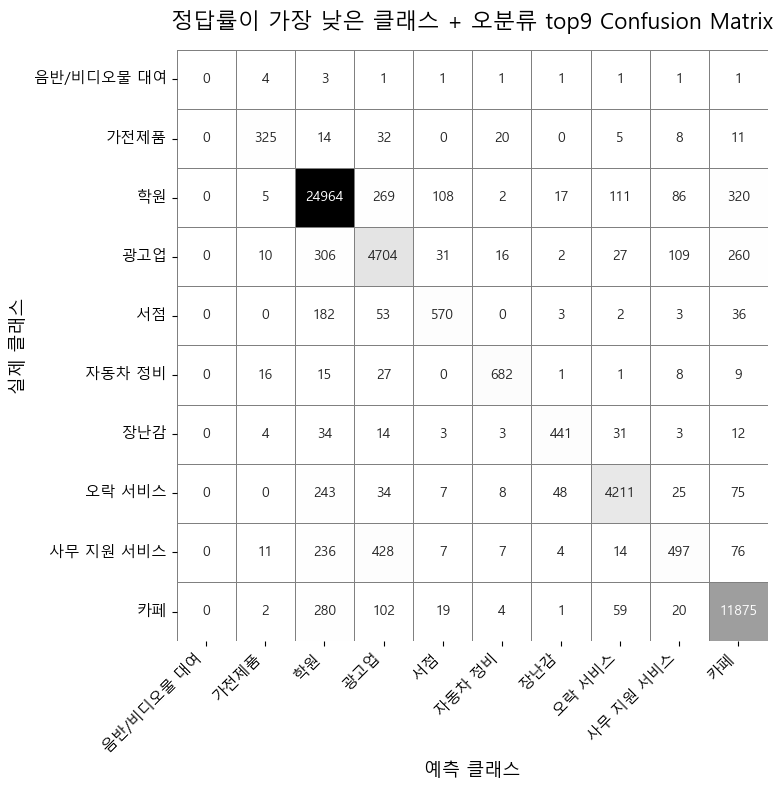

In [44]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

low_idx = np.argmin(correct_ratio)
low_class = unique_classes[low_idx]

row = cm[low_idx].copy()
row[low_idx] = 0
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [low_idx] + list(top9_wrong_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 낮은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [45]:
error_case_ads_df = test_query_df[
    (test_query_df['label'] == '광고 매체 판매') &
    ((test_query_df['pred'] == '광고 대행') |
     (test_query_df['pred'] == '경영 컨설팅'))
    ]
error_case_ads_df

,query,pred,label,prob


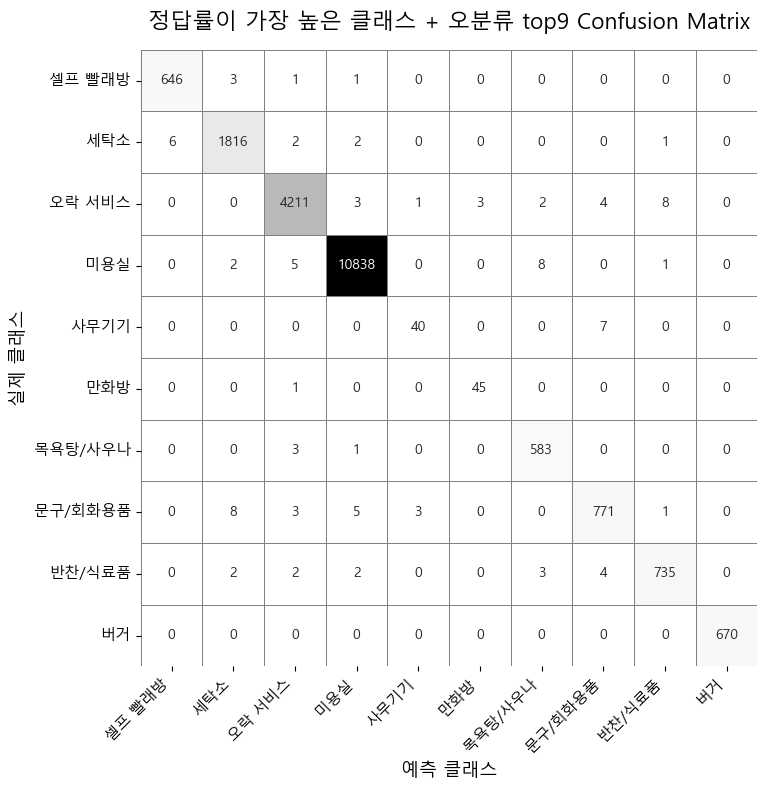

In [46]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

top_idx = np.argmax(correct_ratio)
top_class = unique_classes[top_idx]

row = cm[top_idx].copy()
row[top_idx] = 0  # 자기 자신 제외
top9_correct_idx = np.argsort(row)[-9:][::-1]

selected_idx = [top_idx] + list(top9_correct_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 높은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [47]:
error_case_pinpong_df = test_query_df[test_query_df['label'] == '탁구장']
error_case_pinpong_df

,query,pred,label,prob


In [48]:
def plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=1, topk=9):
    """
    cm: confusion_matrix (numpy array)
    unique_classes: 클래스 이름 리스트 (confusion_matrix의 labels 순서와 동일)
    n: 정답률이 낮은 순서에서 n번째 (1부터 시작)
    topk: 오분류 top k개
    """
    total_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    correct_ratio = correct_counts / (total_counts + 1e-8)
    
    # 정답률 낮은 순서대로 인덱스 정렬
    sorted_idx = np.argsort(correct_ratio)
    nth_idx = sorted_idx[n-1]  # n=1이면 가장 낮은 클래스
    
    row = cm[nth_idx].copy()
    row[nth_idx] = 0  # 자기 자신 제외
    topk_wrong_idx = np.argsort(row)[-topk:][::-1]
    
    selected_idx = [nth_idx] + list(topk_wrong_idx)
    cm_sub = cm[np.ix_(selected_idx, selected_idx)]
    class_labels = [unique_classes[i] for i in selected_idx]
    
    if n <= 0:
        title = f'{abs(n)+1}번째로 정답률이 높은 클래스 + 오분류 top{topk} Confusion Matrix'
    else:
        title = f'{n}번째로 정답률이 낮은 클래스 + 오분류 top{topk} Confusion Matrix'
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub,
                annot=True,
                fmt='d',
                cmap='Greys',
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidths=0.5,
                linecolor='gray',
                cbar=False,
                square=True
                )
    ax = plt.gca()
    for spine in ['right', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color('gray')
    plt.title(title, fontsize=16, pad=15, x=0.27)
    plt.xlabel('예측 클래스', fontsize=13)
    plt.ylabel('실제 클래스', fontsize=13)
    plt.xticks(fontsize=11, rotation=45, ha='right')
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    plt.show()

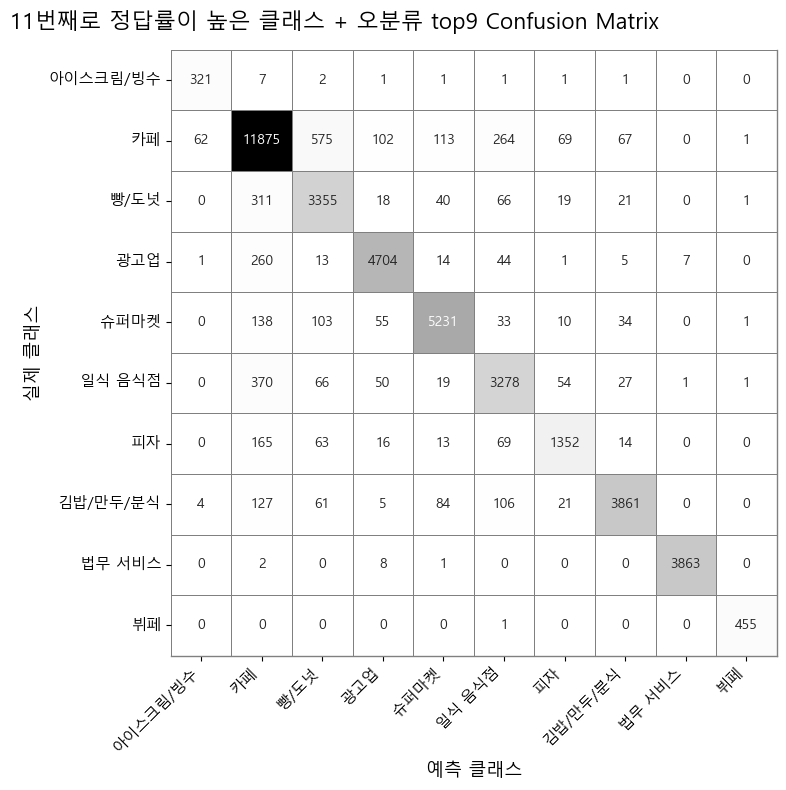

In [64]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=-10, topk=9)

In [50]:
test_query_간이음식점_df = test_query_df[
    (test_query_df['label'] == '간이 음식점(기타)') | (test_query_df['pred'] == '간이 음식점(기타)')
    ]
test_query_간이음식점_df

,query,pred,label,prob


In [51]:
test_query_burger_df = test_query_df[(test_query_df['label'] == '버거')]
error_case_burger_df = test_query_df[(test_query_df['label'] == '버거') & (test_query_df['pred'] != '버거')]
test_query_burger_df

,query,pred,label,prob
457,베스트버거,버거,버거,100.00%
1481,파머스버거,버거,버거,100.00%
1495,버거리창원,버거,버거,100.00%
1644,노브랜드버거군산,버거,버거,100.00%
2356,맘스터치서귀,버거,버거,100.00%
...,...,...,...,...
358922,맘스터치별내1점,버거,버거,100.00%
359987,파이브스타버거,버거,버거,100.00%
360892,노브랜드버거울산대점,버거,버거,100.00%
361736,맘스터치온양,버거,버거,100.00%


In [52]:
error_case_burger_df

,query,pred,label,prob
137699,브로스키친가스트로펍,일식 음식점,버거,89.58%
263735,맥도날드대,피자,버거,57.55%
287970,피치엔버거연천상리점,피자,버거,66.61%
327204,버거앤샌드라빈스,아이스크림/빙수,버거,99.58%
353373,밀크밥버거군산,김밥/만두/분식,버거,99.92%
356290,맥도날드오산세교,피자,버거,59.24%


---
### 모델 간 비교

In [47]:
history_bert_all = pickle.load(open('saved_model/bert-kor_all_2505100105/bert-kor_all_2505100105_history.pkl', 'rb'))
history_bert_MeCab = pickle.load(open('saved_model/bert-kor-mecab_all_2505071730/bert-kor-mecab_all2505071730_history.pkl', 'rb'))
history_bert_CNN = pickle.load(open('saved_model/bert-kor-cnn2_all_2505091730/bert-kor-cnn2_all_2505091730_history.pkl', 'rb'))
history_bert_CNN_W = pickle.load(open('saved_model/bert-kor-cnn_all_2505081630/bert-kor-cnn_all_2505081630_history.pkl', 'rb'))

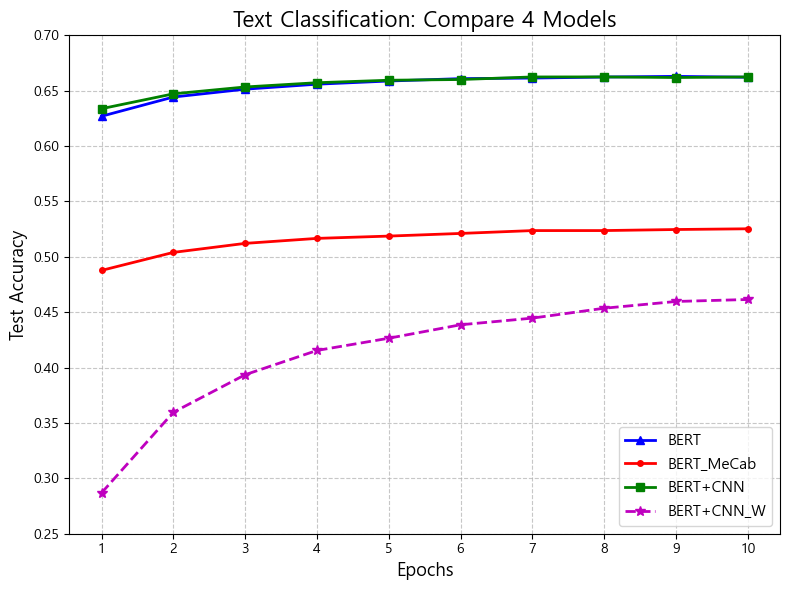

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(history_bert_all["val_acc"], 'b^-', label='BERT', linewidth=2, markersize=6)
plt.plot(history_bert_MeCab["val_acc"], 'r.-', label='BERT_MeCab', linewidth=2, markersize=8)
plt.plot(history_bert_CNN["val_acc"], 'gs-', label='BERT+CNN', linewidth=2, markersize=6)
plt.plot(history_bert_CNN_W["val_acc"], 'm*--', label='BERT+CNN_W', linewidth=2, markersize=7)

plt.title('Text Classification: Compare 4 Models', fontsize=16)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Test Accuracy', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(10),range(1,11))
plt.ylim(0.25, 0.7)
plt.legend(loc='lower right', fontsize=11, frameon=True)
plt.tight_layout()
plt.show()

In [3]:
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

history_bert_CNN = pickle.load(open('saved_model/bert-kor-cnn2_all_2505091730/bert-kor-cnn2_all_2505091730_history.pkl', 'rb'))
history_bert_BN = pickle.load(open('saved_model/bert-kor-cnn4_all_250622_0140/bert-kor-cnn4_all_250622_0140_history.pkl', 'rb'))
history_bert_BO = pickle.load(open('saved_model/bert-kor-cnn5_all_250623_0140/bert-kor-cnn5_all_250623_0140_history.pkl', 'rb'))
history_koelectra = pickle.load(open('saved_model/koelectra-cls_all_250623_0200/koelectra-cls_all_250623_0200_history.pkl', 'rb'))

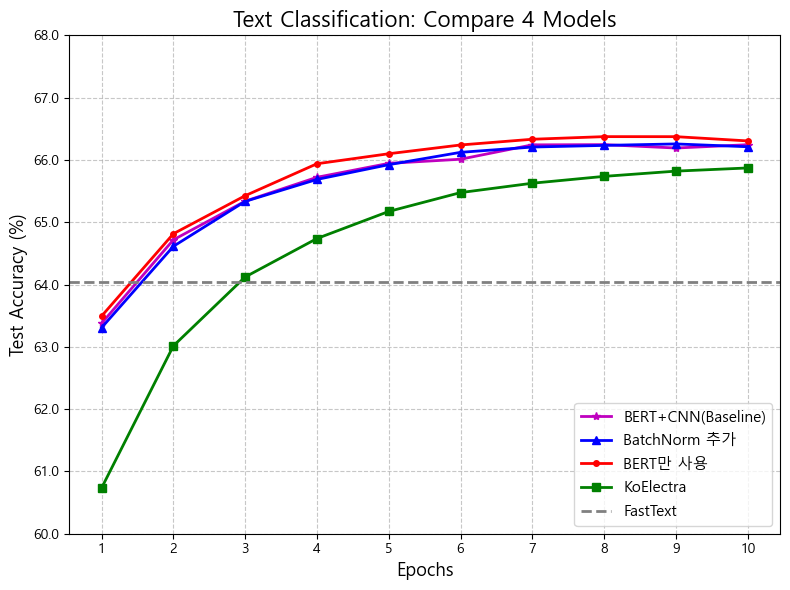

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(history_bert_CNN["val_acc"], 'm*-', label='BERT+CNN(Baseline)', linewidth=2, markersize=6)
plt.plot(history_bert_BN["val_acc"], 'b^-', label='BatchNorm 추가', linewidth=2, markersize=6)
plt.plot(history_bert_BO["val_acc"], 'r.-', label='BERT만 사용', linewidth=2, markersize=8)
plt.plot(history_koelectra["val_acc"], 'gs-', label='KoElectra', linewidth=2, markersize=6)

fasttext_acc = 0.6404
plt.axhline(y=fasttext_acc, color='gray', linestyle='--', linewidth=2, label='FastText')

plt.title('Text Classification: Compare 4 Models', fontsize=16)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Test Accuracy (%)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(10),range(1,11))
plt.ylim(0.6, 0.68)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}'.format(y*100)))
plt.legend(loc='lower right', fontsize=11, frameon=True)
plt.tight_layout()
plt.show()